# RERF

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from lineartree import LinearForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from joblib import dump
import numpy as np

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.regression_metrics import regression

In [4]:
train =  pd.read_parquet('../../../data/model_input/train_sets/house_prices.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/house_prices.parquet')

In [5]:
y_train = train.SalePrice
X_train = train.drop(columns=['SalePrice'])

In [6]:
y_validation = validation.SalePrice
X_validation = validation.drop(columns=['SalePrice'])

In [7]:
scaler = StandardScaler().fit(X_train)

In [8]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [9]:
y_train_scaled = y_train/1000
y_validation_scaled = y_validation/1000

In [10]:
exploratory_depths = [1, 10, 20, 30, 40]
exploratory_estimators = [5, 10, 20, 30, 50, 100]

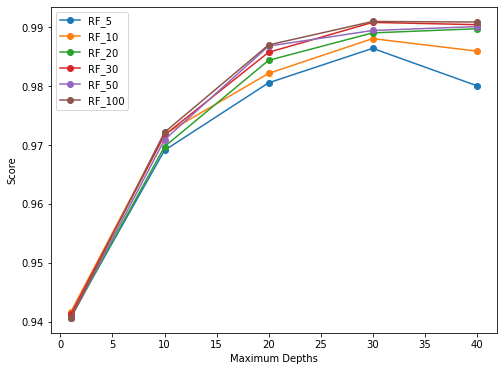

In [11]:
plt.figure(figsize=(8, 6))

for n in exploratory_estimators:
    plt.plot(exploratory_depths, [LinearForestRegressor(base_estimator=LinearRegression(), n_estimators=n, max_features='sqrt', max_depth=i).fit(X_train_scaled, y_train_scaled).score(X_train_scaled, y_train_scaled) for i in exploratory_depths], 
             marker= 'o', label='RF_'+str(n))
    
plt.xlabel('Maximum Depths')
plt.ylabel('Score')
plt.legend()
plt.show()

In [12]:
max_depth = [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 35]
n_estimators = [5, 10, 15, 20, 25, 30]
base_est = [LinearRegression(), Ridge(), Lasso(), ElasticNet(l1_ratio=0.25), ElasticNet(l1_ratio=0.5), ElasticNet(l1_ratio=0.75)]

In [13]:
models_list = []
for n in n_estimators:
    for i in max_depth:
        for est in base_est:
            models_list.append(LinearForestRegressor(base_estimator=est, max_features='sqrt', n_estimators=n, max_depth=i))

In [14]:
names_list = []

for n in n_estimators:
    for depth in max_depth:
        for est in base_est:
            if isinstance(est, LinearRegression):
                name = f'RERF_{depth}_{n}'
            elif isinstance(est, Ridge):
                name = f'RERF_{depth}_{n}_l2'
            elif isinstance(est, Lasso):
                name = f'RERF_{depth}_{n}_l1'
            elif isinstance(est, ElasticNet):
                name = f'RERF_{depth}_{n}_en_{est.l1_ratio}'
            else:
                raise ValueError('Unknown base estimator type')
            
            names_list.append(name)

In [15]:
metrics = regression(models_list, names_list, '../../../data/metrics/house_prices/rerf.csv', X_train_scaled, y_train_scaled, X_validation_scaled, y_validation_scaled, metrics={})
metrics

,Run_Time,Train_RMSE,Validation_RMSE,delta%
RERF_1_5,0.116661,19.327197,35976.133866,186042.535006
RERF_1_5_l2,0.025272,19.023646,36.493788,91.833826
RERF_1_5_l1,0.021940,21.381700,35.736719,67.136939
RERF_1_5_en_0.25,0.023904,23.320567,35.656387,52.896740
RERF_1_5_en_0.5,0.027926,23.077653,36.663075,58.868304
...,...,...,...,...
RERF_35_30_l2,0.173536,8.342672,36.186769,333.755159
RERF_35_30_l1,0.181545,8.048369,33.781011,319.724955
RERF_35_30_en_0.25,0.179517,9.608389,32.320424,236.377149
RERF_35_30_en_0.5,0.180521,9.529217,32.711502,243.275869


In [28]:
metrics[metrics['delta%']<50].sort_values(by='Validation_RMSE')

,Run_Time,Train_RMSE,Validation_RMSE,delta%
RERF_1_20_en_0.25,0.044434,23.271333,34.530442,48.381887
RERF_1_15_en_0.25,0.038898,23.611612,34.898834,47.803689
RERF_1_25_en_0.25,0.062832,23.578367,35.276497,49.613823


We choose **RERF_1_20_en_0.25** as our best model

In [22]:
test =  pd.read_parquet('../../../data/model_input/test_sets/house_prices.parquet')

In [23]:
y_test = test.SalePrice
X_test = test.drop(columns=['SalePrice'])

In [24]:
retrain = pd.concat([train, validation])

In [25]:
y_retrain = retrain.SalePrice
X_retrain = retrain.drop(columns=['SalePrice'])

In [26]:
y_retrain_scaled = y_retrain/1000
y_test_scaled = y_test/1000

In [30]:
scaler_retrain = StandardScaler().fit(X_retrain)

In [31]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [32]:
model = LinearForestRegressor(base_estimator=ElasticNet(l1_ratio=0.25), max_features='sqrt', max_depth=1, n_estimators=20).fit(X_retrain_scaled, y_retrain_scaled)

In [33]:
test_pred = model.predict(X_test_scaled)
rmse = root_mean_squared_error(y_test_scaled, test_pred)
print('Test RMSE:', round(rmse, 4))

Test RMSE: 22.9766


In [34]:
dump(model, 'best_rerf.joblib')

['best_rerf.joblib']

In [35]:
with open('../../../data/metrics/house_prices/final_RMSE.txt', 'a') as f:
    f.write('\nRERF, '+ str(rmse))

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_5156/3753368203.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_retrain_scaled.min(), y_retrain_scaled.max()], [y_retrain_scaled.min(), y_retrain_scaled.max()],


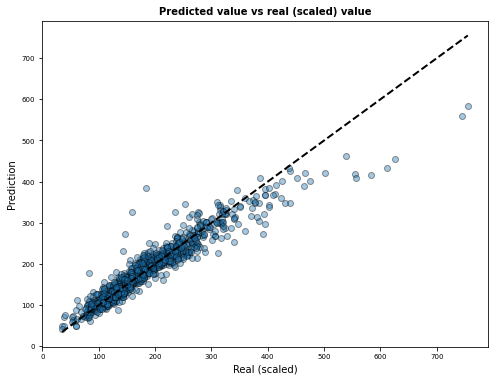

In [36]:
prediction_retrain = model.predict(X_retrain_scaled)
error_retrain   = prediction_retrain - y_retrain_scaled

plt.figure(figsize=(8, 6))

plt.scatter(y_retrain_scaled, prediction_retrain, edgecolors=(0, 0, 0), alpha = 0.4)
plt.plot([y_retrain_scaled.min(), y_retrain_scaled.max()], [y_retrain_scaled.min(), y_retrain_scaled.max()],
                'k--', color = 'black', lw=2)
plt.title('Predicted value vs real (scaled) value', fontsize = 10, fontweight = "bold")
plt.xlabel('Real (scaled)')
plt.ylabel('Prediction')
plt.tick_params(labelsize = 7)